In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import sep
import math
import keras
from keras.utils import np_utils

import numpy as np
from astropy.io import fits
from astropy.visualization import ZScaleInterval
from astropy import wcs
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

import random 
import aplpy
from astroquery.sdss import SDSS

from sklearn.metrics import accuracy_score

np.random.seed(123)  # for reproducibility

Using TensorFlow backend.


Downloading data

In [12]:
data_galaxy = np.load('datasets/galaxy_ic4559_images_scaled.npy')
labels_galaxy = np.load('datasets/galaxy_ic4559_labels_scaled.npy')
data_sim = np.load('datasets/data_sim_scaled_images.npy')
labels_sim = np.load('datasets/data_sim_scaled_labels.npy')

Spliting data to train set and test set

In [3]:
data_A_train = data_sim[0:8000, :,:,0]
data_A_test = data_sim[8000:10000,:,:,0]
data_B_train = data_sim[0:8000, :,:,1]
data_B_test = data_sim[8000:10000,:,:,1]
labels_sim_train = labels_sim[0:8000]
labels_sim_test = labels_sim[8000:10000]
labels2_train = np_utils.to_categorical(labels_sim_train)
labels2_test = np_utils.to_categorical(labels_sim_test)


In [4]:
#we need to transform labels to format (N,2) - now is only (N,1)

CNN - double input

In [5]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras import backend as K


In [6]:
inputA = keras.layers.Input(shape=(21,21))
inputB = keras.layers.Input(shape=(21,21))

# the first branch operates on the first input
x = Dense(64, activation="relu")(inputA)
x = Dense(32, activation="relu")(x)
x = Dense(8, activation="relu")(x)
x = Dense(4, activation="relu")(x)
#x = Model(inputs=inputA, outputs=x)
 
# the second branch opreates on the second input
y = Dense(64, activation="relu")(inputB)
y = Dense(32, activation="relu")(y)
y = Dense(8, activation="relu")(y)
y = Dense(4, activation="relu")(y)
#y = Model(inputs=inputB, outputs=y)
 
# combine the output of the two branches
z = keras.layers.concatenate([x, y], axis=-1)
 
# apply a FC layer and then a regression prediction on the
# combined outputs
z = keras.layers.Flatten()(z)
z= Dense(128, activation='relu')(z)
z= Dense(64, activation='relu')(z)
z= Dense(2, activation='softmax')(z)
 
# our model will accept the inputs of the two branches and
# then output a single value
#model = Model(inputs=[x.input, y.input], outputs=z)
model = Model(inputs=[inputA, inputB], outputs=z)

In [7]:
np.random.seed(4623874)

In [8]:
model.compile(optimizer='adam',
          loss='binary_crossentropy',
          metrics=['accuracy'])

In [9]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 21, 21)       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 21, 21)       0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 21, 64)       1408        input_1[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 21, 64)       1408        input_2[0][0]                    
____________________________________________________________________________________________

In [10]:
history = model.fit([data_A_train, data_B_train],labels2_train, validation_data=([data_A_test, data_B_test], labels2_test), batch_size=20, epochs=30)

#model.fit([data_A, data_B],labels2, batch_size=20, epochs=20)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 8000 samples, validate on 2000 samples
Epoch 1/30
8000/8000 [==============================] - 3s 378us/step - loss: 0.0388 - accuracy: 0.9859 - val_loss: 0.0071 - val_accuracy: 0.9970
Epoch 2/30
8000/8000 [==============================] - 2s 259us/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 1.8817e-05 - val_accuracy: 1.0000
Epoch 3/30
8000/8000 [==============================] - 1s 171us/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 9.1440e-04 - val_accuracy: 0.9995
Epoch 4/30
8000/8000 [==============================] - 1s 135us/step - loss: 1.0626e-04 - accuracy: 0.9999 - val_loss: 4.0127e-06 - val_accuracy: 1.0000
Epoch 5/30
8000/8000 [==============================] - 1s 117us/step - loss: 6.6226e-06 - accuracy: 1.0000 - val_loss: 3.4101e-06 - val_accuracy: 1.0000
Epoch 6/30
8000/8000 [==============================] - 2s 195us/step - loss: 4.4089e-06 - accuracy: 1.

In [21]:
model.save("NNdouble.h5")

In [ ]:
model = load_model("CNNdouble_acc09.h5")

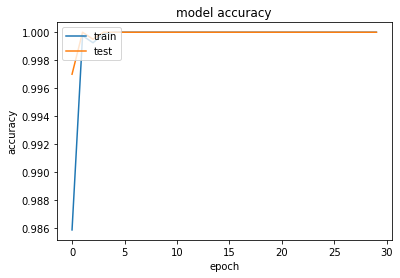

In [22]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy_fun.png')
plt.show()

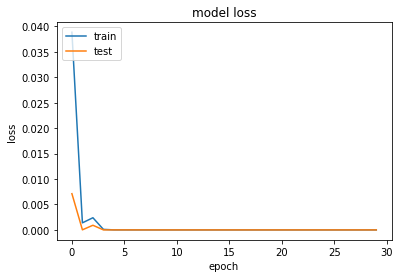

In [23]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss_function_fun.png')
plt.show()


In [13]:
galaxyA = data_galaxy[:,:,:,0]
galaxyB = data_galaxy[:,:,:,1]

In [11]:
labelsx = model.predict([data_galaxy[528:529,:,:,0],data_galaxy[528:529,:,:,1]])

In [12]:
labelsx

array([[0.8880548 , 0.11194526]], dtype=float32)

In [13]:
labelsx2 = model.predict([data_galaxy[:,:,:,0],data_galaxy[:,:,:,1]])

(array([309.,   1.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   1., 323.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ], dtype=float32),
 <a list of 50 Patch objects>)

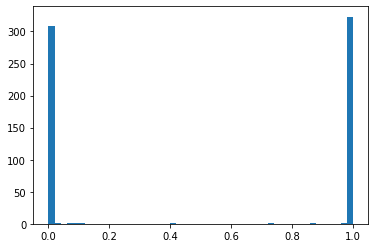

In [18]:
plt.hist(labelsx2[:,1], bins = 50)

In [14]:
labels3 = model.predict([galaxyA,galaxyB])

In [45]:
#labels3 = np.round(labels3)

In [15]:
labels3_pred = np.argmax(labels3, axis=-1)

In [16]:
labels3_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [17]:
accuracy_score(labels_galaxy, labels3_pred)

0.99375

In [18]:
from sklearn.metrics import confusion_matrix

In [19]:
confusion_matrix(labels_galaxy, labels3_pred)

array([[317,   3],
       [  1, 319]])

In [20]:
labels3_pred[528]

0

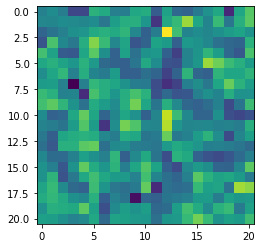

In [28]:
plt.imshow(data_galaxy[528,:,:,1])

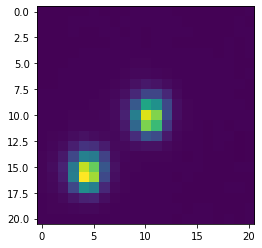

In [29]:
plt.imshow(data_galaxy[528,:,:,0])